<a href="https://colab.research.google.com/github/sayakpaul/Handwriting-Recognizer-in-Keras/blob/main/Initial_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
- Keras example on [Captcha OCR](https://keras.io/examples/vision/captcha_ocr/)

## Dataset collection

In [1]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip

In [2]:
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [3]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Imports

In [4]:
!pip install -q -U imgaug

     |████████████████████████████████| 948 kB 7.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [1]:
from imutils import paths
from tqdm.notebook import tqdm
from itertools import groupby

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import imgaug
import cv2
import os

np.random.seed(42)
tf.random.set_seed(42)

## Dataset preparation

In [2]:
BASE_IMAGE_PATH = os.path.join("data", "words")

In [3]:
# Image path: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
# The above format DOES NOT include the base path which is "data/words" in
# this case.
all_images = list(paths.list_images(BASE_IMAGE_PATH))
all_images[:5]

['data/words/j01/j01-045/j01-045-07-04.png',
 'data/words/j01/j01-045/j01-045-01-01.png',
 'data/words/j01/j01-045/j01-045-00-06.png',
 'data/words/j01/j01-045/j01-045-03-00.png',
 'data/words/j01/j01-045/j01-045-07-00.png']

In [4]:
words_list = []

words = open('data/words.txt', 'r').readlines()
for line in tqdm(words):
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

96456

In [5]:
np.random.shuffle(words_list)

### Prepare the splits (90:5:5)

In [6]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [9]:
# Since the labels start appearing after eighth index we use that
# to retrieve the grounth-truth labels. Remember indexing starts from
# zero in Python.
start_idx = 8
train_words = [line.split(' ')[start_idx:][0].strip() for line in train_samples]
max_label_len = max([len(str(text)) for text in train_words])
print(f"Maximum label length: {max_label_len}")

padding_method = "post"
padding_token = 99
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="\n", char_level=True)
tokenizer.fit_on_texts(train_words)
tokenized_words = tokenizer.texts_to_sequences(train_words)
padded_train_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_words,
                                                        maxlen=max_label_len,
                                                        padding=padding_method,
                                                        value=padding_token)

# Maximum sequence length is 4, hence a word is padded to that length.
print(f"Integer representation of a word: {padded_train_words[0]}")

Maximum label length: 21
Integer representation of a word: [ 7 13  8  1 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


In [10]:
# Unique characters.
len(tokenizer.word_index)

52

In [11]:
# View some word index mappings.
def process_word(word):
    processed_word = []
    for i in word:
        if i != 99:
            processed_word.append(tokenizer.index_word[i])
    return "".join(processed_word)

def view_sample_mappings(sample_padded_words):
    for t in sample_padded_words:
        word = process_word(t)
        print (f"{t.tolist()}----> {word}")

In [12]:
view_sample_mappings(padded_train_words[:15])

[7, 13, 8, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> sure
[9, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> he
[11, 13, 8, 5, 6, 17, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> during
[4, 15, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> of
[20, 4, 4, 2, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> booty
[17, 3, 7, 2, 8, 4, 6, 4, 14, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> gastronomy
[20, 4, 19, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> boy
[2, 9, 1, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> the
[3, 6, 11, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> and
[5, 6, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]----> in
[9, 5, 7, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99,

In [14]:
valid_words = [line.split(' ')[start_idx:][0].strip() for line in validation_samples]
tokenized_valid_words = tokenizer.texts_to_sequences(valid_words)
padded_valid_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_valid_words,
                                                        maxlen=max_label_len,        
                                                        padding=padding_method,
                                                        value=padding_token)

In [15]:
test_words = [line.split(' ')[start_idx:][0].strip() for line in test_samples]
tokenized_test_words = tokenizer.texts_to_sequences(test_words)
padded_test_words = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test_words,
                                                        maxlen=max_label_len,        
                                                        padding=padding_method,
                                                        value=padding_token)

In [16]:
# Credit: https://github.com/githubharald/SimpleHTR/blob/master/src/SamplePreprocessor.py
def distortion_free_resize(image, img_size):
    # Target size and current image size. 
    (wt, ht) = img_size
    (h, w) = image.shape
    
    # Compute the individual resolution scales and take
    # the maximum between them.
    fx = w / wt
    fy = h / ht
    f = max(fx, fy)
    
    # Compute the new image size such that the aspect ratio is respected.
    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))

    # First, resize the image to this newly computed size. Then
    # copy its pixels over appropriately to another blank image
    # having the target size. 
    image = cv2.resize(image, new_size)
    target = np.ones([ht, wt]) * 255
    target[0:new_size[1], 0:new_size[0]] = image
    
    # Tranpose to (w, h) format.
    image = cv2.transpose(target)
    return image

In [17]:
IMG_WIDTH = 128
IMG_HEIGHT = 32

def process_image(img_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):    
    # Read image in grayscale mode.
    image = cv2.imread(img_path, 0)
    # Scale pixel values to [0, 1].
    image = image.astype("float32")/255
    # Resize image.
    image = distortion_free_resize(image, img_size)
    # Add channel otherwise Conv2D won't be compatible.
    image = np.expand_dims(image, axis=-1) 
    return image

In [18]:
def prepare_images(samples):
    images = np.zeros(shape=(len(samples), IMG_WIDTH, IMG_HEIGHT, 1))
    for (i, file_line) in enumerate(tqdm(samples)):
        line_split = file_line.strip()
        line_split = line_split.split(" ")
        
        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0] 
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path =  os.path.join("/content/data/words/", partI, 
            partI + "-" + partII,
            image_name + ".png"
        )
        if os.path.getsize(img_path):
            preprocessed_image = process_image(img_path)
            images[i] = preprocessed_image
    return images

In [19]:
train_images = prepare_images(train_samples)
validation_images = prepare_images(validation_samples)
test_images = prepare_images(test_samples)

In [23]:
# Construct TensorFlow datasets.

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
    imgaug.augmenters.Sometimes(
        0.3,
        imgaug.augmenters.GaussianBlur(sigma=(0, 0.5))
    )
])


def augment(images):
    return augmenter(images=images.numpy())


def make_dicts(images, labels):
    return {"images": images, "labels": labels}


def make_datasets(images, labels, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        dataset = dataset.shuffle(BATCH_SIZE * 25)
    dataset = dataset.batch(BATCH_SIZE)

    if training:
        dataset = dataset.map(
            lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y),
            num_parallel_calls=AUTOTUNE
        )
    dataset = dataset.map(make_dicts).prefetch(AUTOTUNE)
    return dataset

train_dataset = make_datasets(train_images, padded_train_words)
validation_dataset = make_datasets(validation_images, padded_valid_words, False)
test_dataset = make_datasets(test_images, padded_test_words, False)

In [24]:
def plot_samples(images, labels):
    _, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = process_word(labels[i].numpy())
        ax[i // 4, i % 4].imshow(img.squeeze(-1).T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    plt.show()

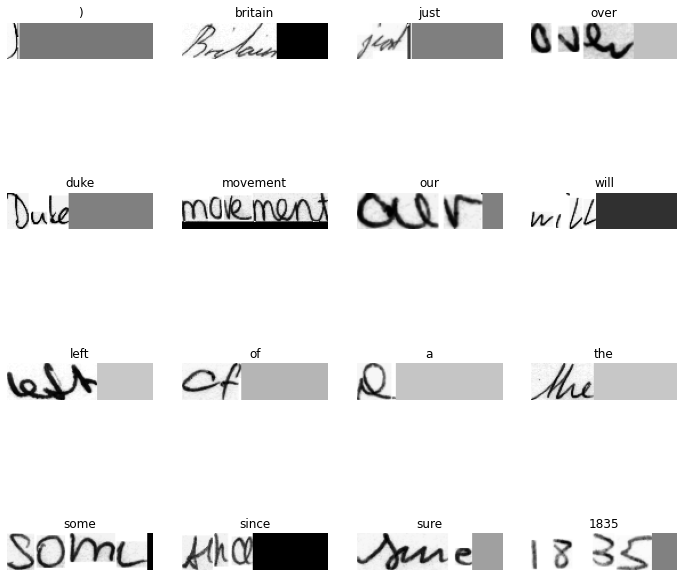

In [25]:
batch = next(iter(train_dataset))
plot_samples(batch["images"], batch["labels"])

## Model building

In [26]:
class CTCLayer( tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img =  tf.keras.layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="images")
    labels =  tf.keras.layers.Input(name="labels", shape=(None,))

    # First conv block
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x =  tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x =  tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x =  tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x =  tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x =  tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x =  tf.keras.layers.Dropout(0.2)(x)

    # RNNs
    x =  tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x =  tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (the tokenizer is char-level)
    # +2 recommendation came from here - https://github.com/MaybeShewill-CV/CRNN_Tensorflow/issues/69#issuecomment-383992527
    x =  tf.keras.layers.Dense(len(tokenizer.word_index) + 2, activation="softmax", name="dense2")(x)
    
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model =  tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         images[0][0]                     
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
_____________________________________________________________________________

## Model training

In [27]:
epochs = 100
early_stopping_patience = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
model = build_model()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
1357/1357 [==============================] - 66s 42ms/step - loss: 13.7039 - val_loss: 12.8109
Epoch 2/100
1357/1357 [==============================] - 57s 42ms/step - loss: 12.3833 - val_loss: 12.3740
Epoch 3/100
1357/1357 [==============================] - 57s 42ms/step - loss: 12.0636 - val_loss: 12.0246
Epoch 4/100
1357/1357 [==============================] - 57s 42ms/step - loss: 11.3540 - val_loss: 10.9796
Epoch 5/100
1357/1357 [==============================] - 57s 42ms/step - loss: 10.4784 - val_loss: 9.9197
Epoch 6/100
1357/1357 [==============================] - 57s 42ms/step - loss: 9.8998 - val_loss: 9.4077
Epoch 7/100
1357/1357 [==============================] - 57s 42ms/step - loss: 9.4814 - val_loss: 8.9178
Epoch 8/100
1357/1357 [==============================] - 57s 42ms/step - loss: 9.0652 - val_loss: 8.5845
Epoch 9/100
1357/1357 [==============================] - 57s 42ms/step - loss: 8.6633 - val_loss: 8.0102
Epoch 10/100
1357/1357 [======================

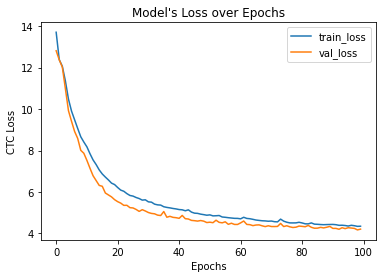

In [28]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("CTC Loss")
plt.title("Model's Loss over Epochs")
plt.legend()
plt.show()

In [30]:
# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(
    model.get_layer(name="images").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 64)         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 512)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            32832 

In [31]:
# Reference: https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/CRNN_CTC_wandb.ipynb
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(tokenizer.index_word) + 1:
                ans += tokenizer.index_word[int(p)]
        
        text_list.append(ans)
        
    return text_list

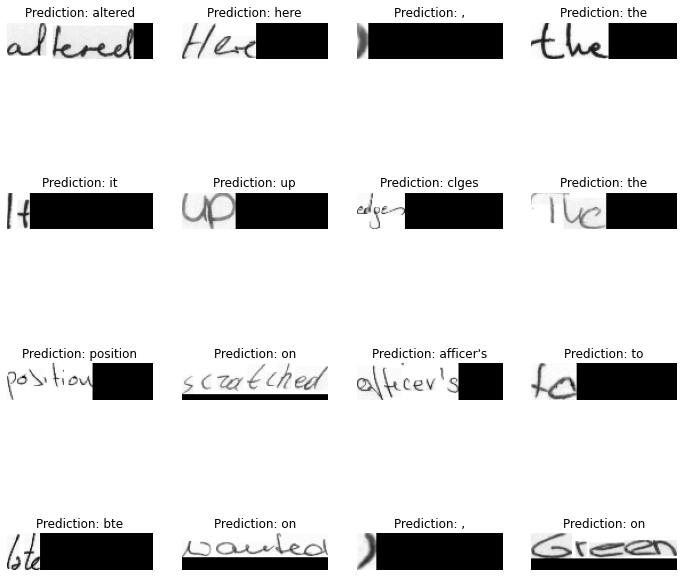

In [32]:
#  Let's check results on some test samples.

for batch in test_dataset.take(1):

    batch_images = batch["images"]
    batch_labels = batch["labels"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    fig , ax = plt.subplots(4, 4, figsize=(12, 12))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img.T, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()